Data Collection + Part of Data Cleaning 
---


Part One
---
The code for my first dataset- scraping


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import re

def download_university_information(out_file1: str, sample_p: bool,url:str): #more specific name 
    count=0
    sub_url=url.rstrip('us/')
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    except:
        print ('have error accessing the web')
    else:
        with open(out_file1, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['University', 'Rank', 'Zip Code', 'Website', 'Undergrad Local Tuition', 'Undergrad International Tuition']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            table = soup.find('table', {'class': 'table table-hover'})

            for row in table.find_all('tr'):
                count+=1
                cells = row.find_all('td')

                if len(cells) >= 3:
                    university_name = cells[1].text.strip()
                    university_rank = cells[0].text.strip()
                    university_website_temp = cells[1].find('a')['href']
                    university_website = f"{sub_url}{university_website_temp}"

                    university_response = requests.get(university_website)
                    university_soup = BeautifulSoup(university_response.text, 'html.parser')

                    zip_code_tag = university_soup.find('span', {'itemprop': 'postalCode'})
                    zip_code = zip_code_tag.text.strip() if zip_code_tag else "Zip code not found"
                    if "-" in zip_code:
                        zip_code1=zip_code
                        zip_code=(re.findall(r'(.*?)-',zip_code1))[0]
                    zip_code="'"+(str(zip_code))+"'"

                    tuition_tables = university_soup.find_all('tbody')
                    if len(tuition_tables) >= 2:
                        tuition_table = tuition_tables[2]
                        tuition_rows = tuition_table.find_all('tr')
                        #print(tuition_rows)
                        counta=0
                        for row in tuition_rows:
                            #print(row)
                            cells = row.find_all('td')
                            #print (cells)
                            
                            if len(cells) >= 2:
                                if counta==0:
                                    local_tuition1 = cells[0].get_text(strip=True)
                                    try:
                                        local_tuition=(re.findall(r'(.*?) US\$',local_tuition1))[0].replace(',','')
                                    except:
                                        local_tuition=local_tuition1
                                    #print("Local Tuition:", local_tuition)
                                elif counta==1:
                                    intl_tuition1 = cells[0].get_text(strip=True)
                                    try:
                                        intl_tuition=(re.findall(r'(.*?) US\$',intl_tuition1))[0].replace(',','')
                                    except:
                                        intl_tuition=intl_tuition1
                                    #print("Intl Tuition:", intl_tuition)
                                
                                counta+=1

                    else:
                        local_tuition = "Tuition information not available"
                        intl_tuition = "Tuition information not available"    
                    
                    writer.writerow({
                        'University': university_name,
                        'Rank': university_rank,
                        'Zip Code': zip_code,
                        'Website': university_website,
                        'Undergrad Local Tuition': local_tuition,
                        'Undergrad International Tuition': intl_tuition
                    })
                    #print(count)
                if sample_p==True:
                    if count==6:
                        break

        print("CSV file is ok")

In [ ]:
download_university_information('universities_sample.csv', True, "https://www.4icu.org/us/") 

In [ ]:
download_university_information('universities_sample.csv', False, "https://www.4icu.org/us/") 

In [ ]:
tuition_replacements = {
    'Not reported': 'NA',
    '0-999': 1,
    '1000-2499': 2,
    '2500-4999': 3,
    '5000-7499': 4,
    '7500-9999': 5,
    '10000-12499': 6,
    '12500-14999': 7,
    '15000-17499': 8,
    '17500-19999': 9,
    '20000-24999': 10,
    'over 20000': 11,
    '25000-29999': 12,
    '30000-34999': 13,
    '35000-39999': 14,
    '40000-44999': 15,
    '45000-49999': 16,
    'over 50000': 17
}

In [ ]:
import pandas as pd

def replace_values(column, replacements):
    for old, new in replacements.items():
        column = column.replace(old, new)
    return column

def data_cleaning_part_1(input_name: str, output_name: str):
    df = pd.read_csv(input_name, header=0)
    
    df['Undergrad International Tuition'] = replace_values(df['Undergrad International Tuition'], tuition_replacements)
    df['Undergrad Local Tuition'] = replace_values(df['Undergrad Local Tuition'], tuition_replacements)

    df['Undergrad Local Tuition'] = df['Undergrad Local Tuition'].replace('NA', pd.NA)
    df['Undergrad International Tuition'] = df['Undergrad International Tuition'].replace('NA', pd.NA)

    df = df.dropna(subset=['Undergrad Local Tuition', 'Undergrad International Tuition'])

    df['Average Tuition'] = (df['Undergrad Local Tuition'] + df['Undergrad International Tuition']) / 2

    df = df[df['Rank'] != 'Un']

    df.to_csv(output_name, index=False)

In [ ]:
data_cleaning_part_1('universities_sample.csv','universities_sample_clean.csv')

Part Two
---
The code for my second dataset- API

the website of API is https://zylalabs.com/api-marketplace/data/crime+data+by+zipcode+api/824. If the API key has expired, the code here still works, but it won't get any useful information and every cell will be "NA". To get useful information, we can just renew the API key by changing it when calling the function.

In [ ]:
import csv

def read_zip_codes(csv_file):
    zip_codes = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            zip_code = row.get('Zip Code')
            if zip_code is not None:
                zip_codes.append(str(zip_code).strip("'"))
    return zip_codes

csv_file = 'universities_sample.csv'
zip_code_list = read_zip_codes(csv_file)
#print(zip_code_list)

In [ ]:
def get_value(data, keys):
    try:
        for key in keys:
            data = data[key]
        return data
    except (KeyError, IndexError):
        return 'NA'

In [ ]:
import requests
import csv
from collections import defaultdict

def download_crime_rate(out_file1:str, out_file2: str, sample_p: bool, url:str,payload:str): 
    count=0
    zip_code_list = read_zip_codes(out_file1)

    fieldnames = ['Zip Code', 'Overall Grade', 'Crime Frequency', 'Violent Crime Rate', 'Property Crime Rate']

    csv_filename = out_file2

    headers = {
        'Authorization': 'Bearer 4210|x4Jvwf01DeQX5URPAvSvRIS7SUJrSWiu5vkD5IOk'
    }

    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        for zip_code in zip_code_list:
            count+=1
            full_url = url + zip_code
            #print(full_url)

            try:
                response = requests.request("GET", full_url, headers=headers, data=payload) 
                data = response.json()
                
                overall_grade = get_value(data, ['Overall', 'Overall Crime Grade'])
                crime_freq = get_value(data, ['Overall', 'Fact'])
                violent_crime_rate = get_value(data, ['Crime BreakDown', 0, '0', 'Total Violent Crime'])
                property_crime_rate = get_value(data, ['Crime BreakDown', 1, '0', 'Total Property Crime'])
                zip_code1="'"+zip_code+"'"

                writer.writerow({
                    'Zip Code': zip_code1,
                    'Overall Grade': overall_grade,
                    'Crime Frequency': crime_freq,
                    'Violent Crime Rate': violent_crime_rate,
                    'Property Crime Rate': property_crime_rate
                })
            except:
                print(f"requests failure: {response.text}")
            if sample_p==True:
                if count==6:
                    break

In [ ]:
download_crime_rate('universities_sample.csv', 'crime_data_sample.csv', True, 
                    'https://zylalabs.com/api/824/crime+data+by+zipcode+api/583/get+crime+rates+by+zip?zip=',
                    '4196|gOtjwOuGc8dwI5m7xJC226atj5ju1hNrz4h73lPJ') #download sample dataset like this

In [ ]:
import pandas as pd
df = pd.read_csv(r'crime_data.csv', header=0)

In [ ]:
import csv

def column_to_list(csv_file, column_name):
    result = []
    with open(csv_file, 'r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            result.append(row[column_name])
    return result

csv_file = 'crime_data.csv'  
column_name = 'Crime Frequency'  
column_list = column_to_list(csv_file, column_name)
print(column_list)

In [ ]:
new_list=[]
for item in column_list:
    words=item.split()
    if 'day' in item:
        days=int(words[4])
        hours=int(words[6])
        frequency=str(days*24+hours)
    elif 'hour' in item:
        hours=int(words[4])
        minutes=int(words[6])
        frequency=str(hours+(minutes/60))
    elif 'minute' in item and 'hour' not in item:
        munites=int(words[4])
        frequency=str((minutes/60))
    else:
        frequency='NA'
    new_list.append(frequency)

In [ ]:
df['Frequency in Hours'] = new_list
df = df.replace('NA', pd.NA)
df.dropna(inplace=True)
df.to_csv('clean_crime_data.csv', index=False)

Data Cleaning
---

Dataset 1
---
The code for my first dataset- scraping

Data cleaning process

In [1]:
import pandas as pd

def replace_values(column, replacements):
    for old, new in replacements.items():
        column = column.replace(old, new)
    return column

def data_cleaning_part_1(input_name: str, output_name: str):
    df = pd.read_csv(input_name, header=0)

    df['Undergrad International Tuition'] = replace_values(df['Undergrad International Tuition'], tuition_replacements)
    df['Undergrad Local Tuition'] = replace_values(df['Undergrad Local Tuition'], tuition_replacements)

    df['Undergrad Local Tuition'] = df['Undergrad Local Tuition'].replace('NA', pd.NA)
    df['Undergrad International Tuition'] = df['Undergrad International Tuition'].replace('NA', pd.NA)

    df = df.dropna(subset=['Undergrad Local Tuition', 'Undergrad International Tuition'])

    df['Average Tuition'] = (df['Undergrad Local Tuition'] + df['Undergrad International Tuition']) / 2

    df = df[df['Rank'] != 'Un']

    df.to_csv(output_name, index=False)

use the sample dataset as an example here

In [5]:
data_cleaning_part_1(r'universities_sample.csv',r'universities_sample_clean.csv')

C:\Users\曾雯\AppData\Local\Temp\ipykernel_23236\3344281629.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  column = column.replace(old, new)


Dataset 2
---
The code for my second dataset- API

In [186]:
import pandas as pd
df = pd.read_csv(r'crime_data.csv', header=0)

In [166]:
import csv

def column_to_list(csv_file, column_name):
    result = []
    with open(csv_file, 'r', newline='') as file:
        reader = csv.DictReader(file)
        
        for row in reader:
            result.append(row[column_name])
    return result

csv_file = 'crime_data.csv'  
column_name = 'Crime Frequency'  
column_list = column_to_list(csv_file, column_name)
print(column_list)

['A crime occurs every 6 hours 53 minutes (on average) in 02139.', 'A crime occurs every 3 hours 59 minutes (on average) in 02138.', 'A crime occurs every 4 hours 29 minutes (on average) in 94305.', 'A crime occurs every 1 day 7 hours (on average) in 14853.', 'A crime occurs every 4 hours 59 minutes (on average) in 94720.', 'A crime occurs every 3 hours 7 minutes (on average) in 48109.', 'A crime occurs every 6 hours 15 minutes (on average) in 98195.', 'A crime occurs every 1 hour 5 minutes (on average) in 10027.', 'A crime occurs every 1 hour 28 minutes (on average) in 19104.', 'NA', 'A crime occurs every 1 hour 23 minutes (on average) in 53706.', 'A crime occurs every year or more (on average) in 90095.', 'A crime occurs every 1 day 11 hours (on average) in 78712.', 'A crime occurs every 3 days 22 hours (on average) in 08544.', 'A crime occurs every 4 days 20 hours (on average) in 47907.', 'A crime occurs every 1 hour 31 minutes (on average) in 60637.', 'A crime occurs every 4 hours 

In [187]:
new_list=[]
for item in column_list:
    words=item.split()
    #print(words)
    if 'day' in item:
        days=int(words[4])
        hours=int(words[6])
        frequency=str(days*24+hours)
    elif 'hour' in item:
        hours=int(words[4])
        minutes=int(words[6])
        frequency=str(hours+(minutes/60))
    elif 'minute' in item and 'hour' not in item:
        munites=int(words[4])
        frequency=str((minutes/60))
    else:
        frequency='NA'
    new_list.append(frequency)

In [189]:
df['Frequency in Hours'] = new_list

In [192]:
df = df.replace('NA', pd.NA)
df.dropna(inplace=True)

In [193]:
df.to_csv('clean_crime_data.csv', index=False)

Dataset 3 
---
CSV donwloaded online

In [19]:
import pandas as pd

df = pd.read_csv(r'Zip_zhvi.csv')

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,211762.078497,...,481531.770944,484344.303191,486839.034009,488672.706004,489922.034733,490617.836202,491236.726086,492622.821494,494800.990956,497633.682304
1,61148,2,8701,zip,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,136347.909387,...,542238.662882,548302.186761,554154.067399,560433.407041,567721.642074,574474.890368,579209.518786,580782.188877,583321.836136,588383.424533
2,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,104175.310235,...,278227.439797,278994.484354,279898.384349,280436.466336,280426.174856,280189.442068,279896.109545,280253.140473,280957.697887,282060.397358
3,62080,4,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,152494.806838,...,476324.274236,474446.810636,474440.684258,473866.596636,471779.210068,468324.559266,463909.897770,460996.451203,459344.390448,462496.331770
4,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,103152.397820,...,273028.966082,273881.886467,274764.885973,275197.791142,275188.033750,274762.886408,274336.157995,274382.565892,274912.162081,275920.544246


In [20]:
columns_to_keep = ['RegionName', '2023-06-30','2023-09-30', '2023-12-31','2024-03-31']  
df = df[columns_to_keep]

In [21]:
def add_zero_if_length_5(value):
    value=str(value)
    if len(value) == 4:
        return '0' + value
    else:
        return value

df['RegionName'] = df['RegionName'].apply(add_zero_if_length_5)
df['Average House Price']=(df['2023-06-30']+df['2023-09-30']+df['2023-12-31']+df['2024-03-31'])/4

df.head()
df.to_csv(r'clean_Zip_zhvi.csv', index=False)

EDA
---

Dataset 1 EDA
---

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [24]:
df1 = pd.read_csv(r'universities_clean.csv')
df1.head()

,University,Rank,Zip Code,Website,Undergrad Local Tuition,Undergrad International Tuition,Average Tuition
0,Massachusetts Institute of Technology,1,'02139',https://www.4icu.org//reviews/5728.htm,17,17,17.0
1,Harvard University,2,'02138',https://www.4icu.org//reviews/5720.htm,17,17,17.0
2,Stanford University,3,'94305',https://www.4icu.org//reviews/5135.htm,17,17,17.0
3,Cornell University,4,'14853',https://www.4icu.org//reviews/6077.htm,17,17,17.0
4,"University of California, Berkeley",5,'94720',https://www.4icu.org//reviews/5143.htm,7,15,11.0


In [318]:
df1.shape

(1642, 7)

In [27]:
df1.describe().round(decimals=2)

,Rank,Undergrad Local Tuition,Undergrad International Tuition,Average Tuition
count,1642.00,1642.00,1642.00,1642.00
mean,851.39,10.06,11.52,10.79
std,496.46,4.51,3.48,3.86
min,1.00,1.00,1.00,1.00
25%,420.25,6.00,9.00,7.00
50%,849.50,10.00,12.00,10.00
75%,1276.75,14.00,14.00,14.00
max,1731.00,17.00,17.00,17.00


In [148]:
zip_code_count=df1['Zip Code'].value_counts()


Zip Code
'02115'    8
'91711'    5
'02116'    4
'46556'    3
'52001'    3
          ..
'84720'    1
'02141'    1
'47712'    1
'07083'    1
'45680'    1
Name: count, Length: 1500, dtype: int64


In [33]:
tuition_replacements_inverse = {v: k for k, v in tuition_replacements.items()}

In [152]:
df1_1 = df1.copy()
df1_1['Undergrad Local Tuition'] = df1['Undergrad Local Tuition'].replace(tuition_replacements_inverse)
df1_1['Undergrad International Tuition'] = df1['Undergrad International Tuition'].replace(tuition_replacements_inverse)
df1_1['Average Tuition'] = df1['Average Tuition'].replace(tuition_replacements_inverse)


In [260]:
df1_1.head(10)

,University,Rank,Zip Code,Website,Undergrad Local Tuition,Undergrad International Tuition,Average Tuition
0,Massachusetts Institute of Technology,1,'02139',https://www.4icu.org//reviews/5728.htm,over 50000,over 50000,over 50000
1,Harvard University,2,'02138',https://www.4icu.org//reviews/5720.htm,over 50000,over 50000,over 50000
2,Stanford University,3,'94305',https://www.4icu.org//reviews/5135.htm,over 50000,over 50000,over 50000
3,Cornell University,4,'14853',https://www.4icu.org//reviews/6077.htm,over 50000,over 50000,over 50000
4,"University of California, Berkeley",5,'94720',https://www.4icu.org//reviews/5143.htm,12500-14999,40000-44999,over 20000
5,University of Michigan,6,'48109',https://www.4icu.org//reviews/5821.htm,15000-17499,over 50000,12.5
6,University of Washington,7,'98195',https://www.4icu.org//reviews/6835.htm,10000-12499,35000-39999,20000-24999
7,Columbia University in the City of New York,8,'10027',https://www.4icu.org//reviews/6075.htm,over 50000,over 50000,over 50000
8,University of Pennsylvania,9,'19104',https://www.4icu.org//reviews/6506.htm,over 50000,over 50000,over 50000
9,Yale University,10,'06520',https://www.4icu.org//reviews/5233.htm,over 50000,over 50000,over 50000


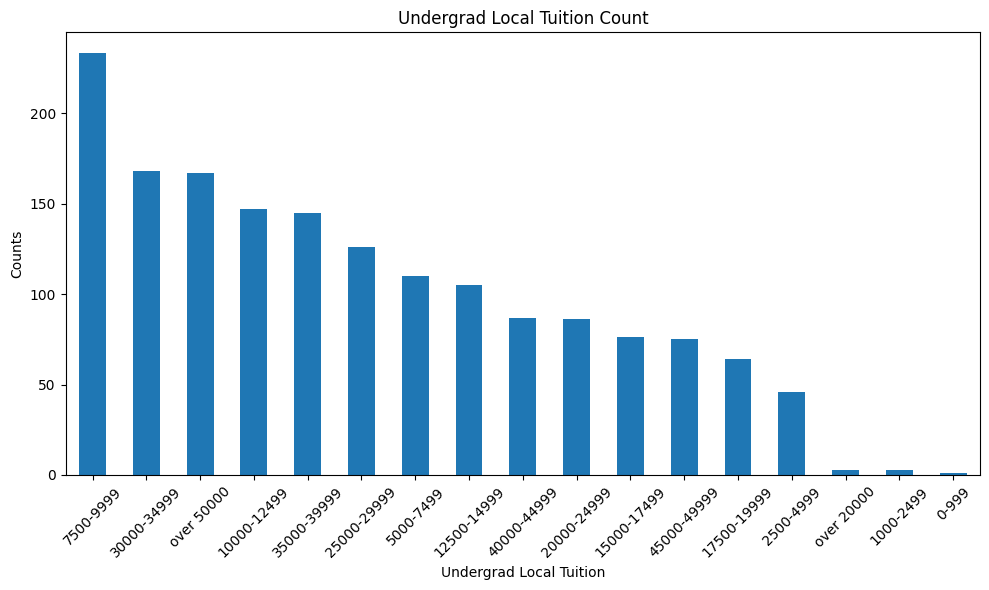

In [40]:
local_tuition = df1_1['Undergrad Local Tuition'].value_counts()

plt.figure(figsize=(10, 6)) 
local_tuition.plot(kind='bar')
plt.title('Undergrad Local Tuition Count')
plt.xlabel('Undergrad Local Tuition')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

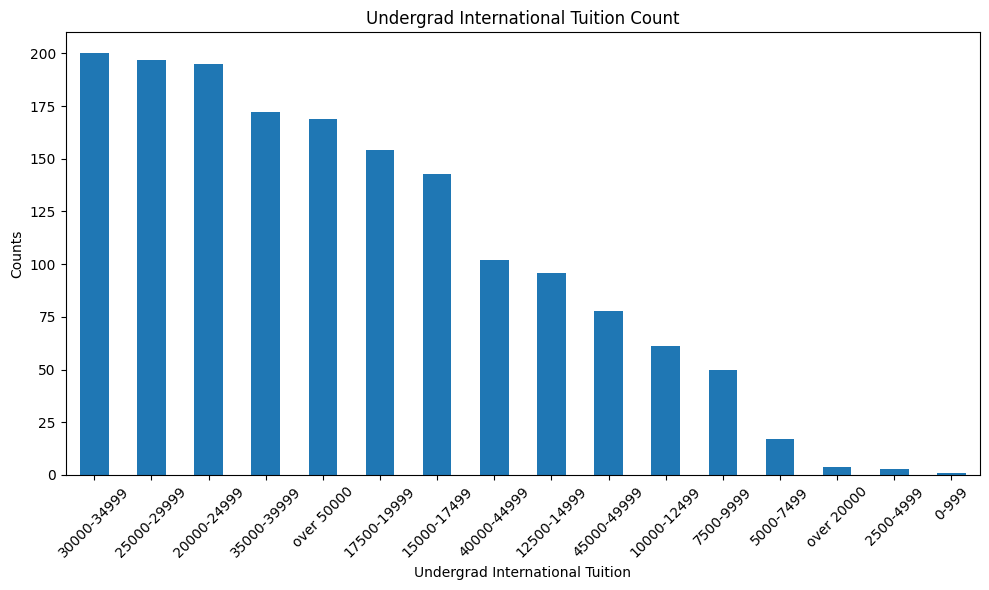

In [41]:
local_tuition = df1_1['Undergrad International Tuition'].value_counts()

plt.figure(figsize=(10, 6)) 
local_tuition.plot(kind='bar')
plt.title('Undergrad International Tuition Count')
plt.xlabel('Undergrad International Tuition')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

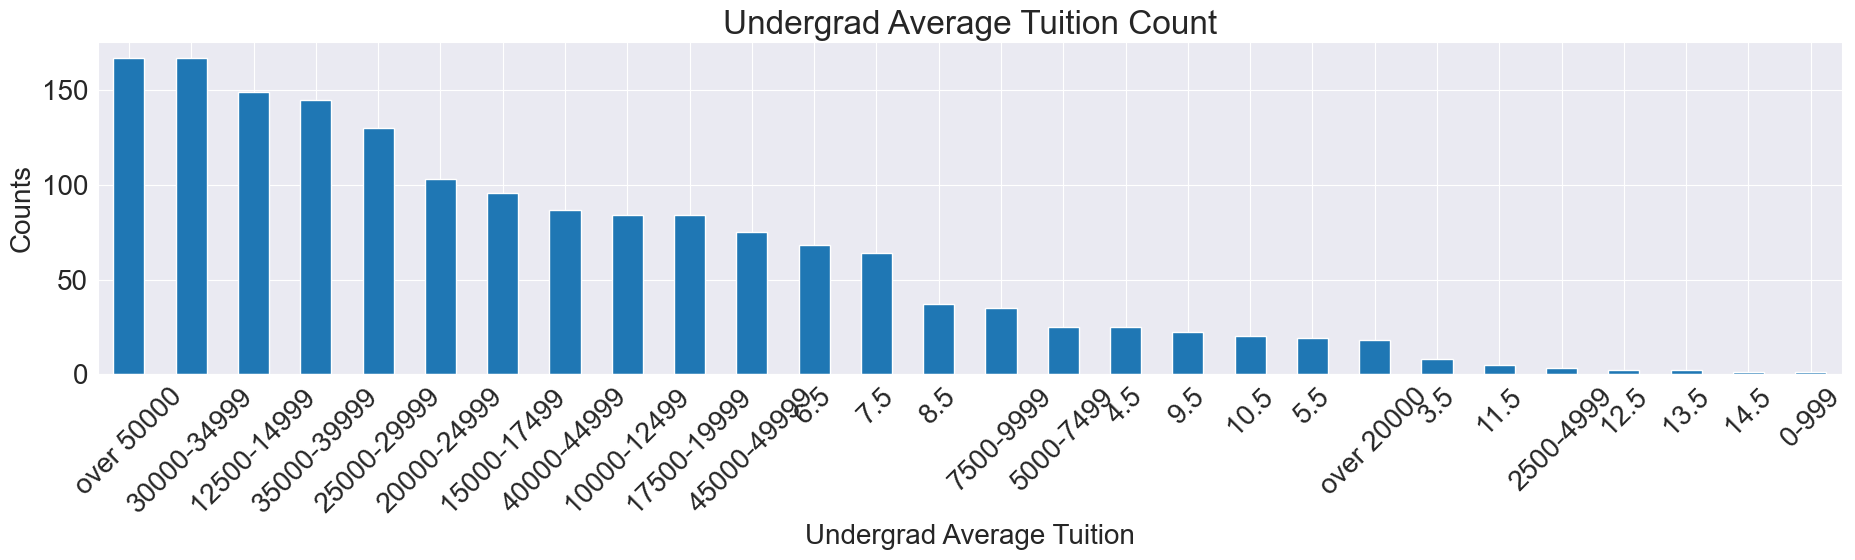

In [333]:
local_tuition = df1_1['Average Tuition'].value_counts()

plt.figure(figsize=(19, 6)) 
local_tuition.plot(kind='bar')
plt.title('Undergrad Average Tuition Count')
plt.xlabel('Undergrad Average Tuition')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

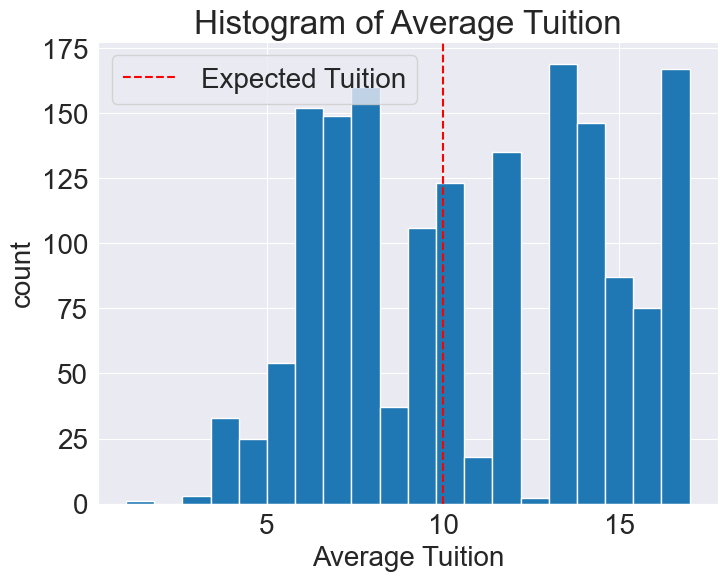

In [340]:
expected_value = df1['Average Tuition'].median() 

plt.figure(figsize=(8, 6))
plt.hist(df1['Average Tuition'], bins=20)  
plt.axvline(expected_value, color='red', linestyle='--', label='Expected Tuition')  
plt.title('Histogram of Average Tuition')
plt.xlabel('Average Tuition')
plt.ylabel('count')
plt.legend() 

plt.show()

In [49]:
df_subset = df1.head(100)

df_subset_new = df_subset.copy()

df_subset_new['Undergrad Local Tuition'] = df_subset['Undergrad Local Tuition']

df_subset_new.head()

,University,Rank,Zip Code,Website,Undergrad Local Tuition,Undergrad International Tuition,Average Tuition
0,Massachusetts Institute of Technology,1,'02139',https://www.4icu.org//reviews/5728.htm,17,17,17.0
1,Harvard University,2,'02138',https://www.4icu.org//reviews/5720.htm,17,17,17.0
2,Stanford University,3,'94305',https://www.4icu.org//reviews/5135.htm,17,17,17.0
3,Cornell University,4,'14853',https://www.4icu.org//reviews/6077.htm,17,17,17.0
4,"University of California, Berkeley",5,'94720',https://www.4icu.org//reviews/5143.htm,7,15,11.0


In [50]:
df_subset_new.describe()

,Rank,Undergrad Local Tuition,Undergrad International Tuition,Average Tuition
count,100.00000,100.000000,100.000000,100.000000
mean,50.81000,10.170000,14.410000,12.290000
std,29.38518,5.164085,2.523005,3.694235
min,1.00000,4.000000,4.000000,4.000000
25%,25.75000,6.000000,13.000000,9.500000
50%,50.50000,7.500000,14.000000,11.000000
75%,76.25000,17.000000,17.000000,17.000000
max,101.00000,17.000000,17.000000,17.000000


Dataset 2 EDA
---

In [51]:
df2 = pd.read_csv(r'clean_crime_data.csv')
df2.head()

,Zip Code,Overall Grade,Crime Frequency,Violent Crime Rate,Property Crime Rate,Frequency in Hours
0,'02139',C-,A crime occurs every 6 hours 53 minutes (on av...,4.434,23.67,6.883333
1,'02138',F,A crime occurs every 3 hours 59 minutes (on av...,8.416,38.95,3.983333
2,'94305',D-,A crime occurs every 4 hours 29 minutes (on av...,7.027,36.73,4.483333
3,'14853',F,A crime occurs every 1 day 7 hours (on average...,7.908,53.5,31.000000
4,'94720',F,A crime occurs every 4 hours 59 minutes (on av...,17.54,231.6,4.983333


In [88]:
df2['Violent Crime Rate']=df2['Violent Crime Rate'].str.replace(',', '').astype(float)
df2['Property Crime Rate']=df2['Property Crime Rate'].str.replace(',', '').astype(float)
df2.describe()

,Violent Crime Rate,Property Crime Rate,Frequency in Hours
count,1553.000000,1553.000000,1553.000000
mean,10.947510,83.148769,56.026637
std,127.437466,644.611554,150.832441
min,0.391900,0.701700,0.016667
25%,2.216000,11.580000,5.416667
50%,3.814000,20.360000,10.683333
75%,6.672000,36.260000,26.000000
max,4922.000000,18647.000000,838.000000


In [75]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Zip Code             1553 non-null   object 
 1   Overall Grade        1553 non-null   object 
 2   Crime Frequency      1553 non-null   object 
 3   Violent Crime Rate   1553 non-null   object 
 4   Property Crime Rate  1553 non-null   object 
 5   Frequency in Hours   1553 non-null   float64
dtypes: float64(1), object(5)
memory usage: 72.9+ KB


In [319]:
df2.shape

(1553, 6)

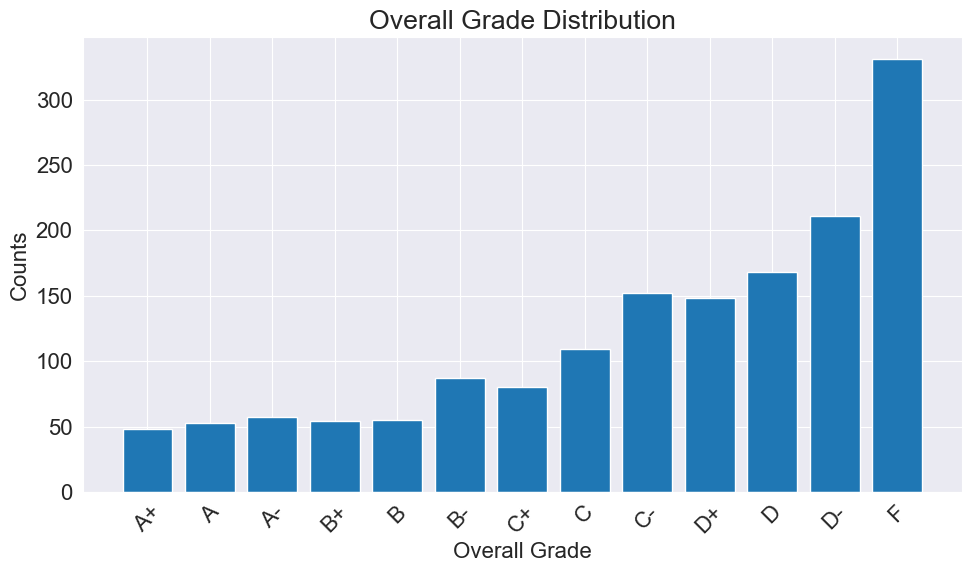

In [170]:
index_order = ["A+","A","A-","B+","B","B-","C+","C","C-","D+","D","D-","F"]
df2_sorted = df2['Overall Grade'].value_counts().reindex(index_order)  

plt.figure(figsize=(10, 6)) 
plt.bar(df2_sorted.index, df2_sorted.values)  
plt.title('Overall Grade Distribution')
plt.xlabel('Overall Grade')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

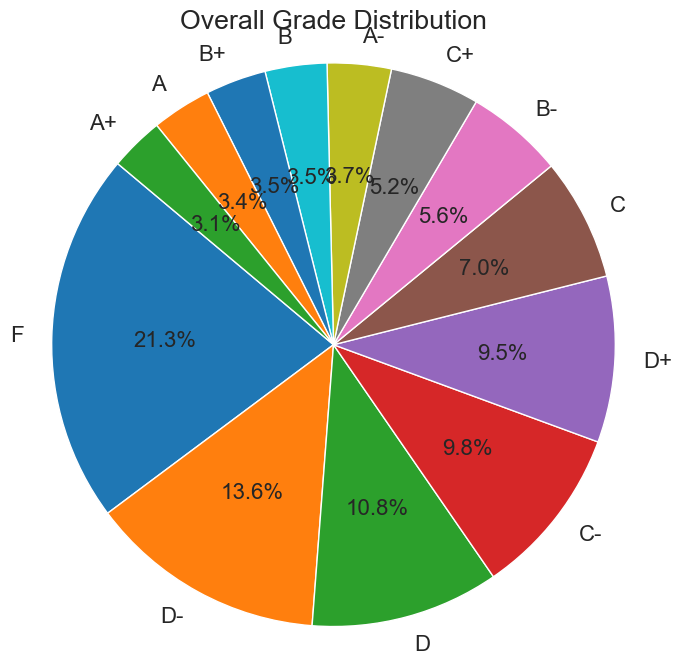

In [171]:
grade_counts = df2['Overall Grade'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', startangle=140)

plt.axis('equal')
plt.title('Overall Grade Distribution')
plt.show()

In [77]:
df2_new = df2.copy()
df2_new['Violent Crime Rate']=df2_new['Violent Crime Rate'].str.replace(',', '').astype(float).round(0)
df2_new['Property Crime Rate']=df2_new['Property Crime Rate'].str.replace(',', '').astype(float).round(0)
df2_new['Frequency in Hours']=df2_new['Frequency in Hours'].round(0)

In [79]:
df2_new.head()

,Zip Code,Overall Grade,Crime Frequency,Violent Crime Rate,Property Crime Rate,Frequency in Hours
0,'02139',C-,A crime occurs every 6 hours 53 minutes (on av...,4.0,24.0,7.0
1,'02138',F,A crime occurs every 3 hours 59 minutes (on av...,8.0,39.0,4.0
2,'94305',D-,A crime occurs every 4 hours 29 minutes (on av...,7.0,37.0,4.0
3,'14853',F,A crime occurs every 1 day 7 hours (on average...,8.0,54.0,31.0
4,'94720',F,A crime occurs every 4 hours 59 minutes (on av...,18.0,232.0,5.0


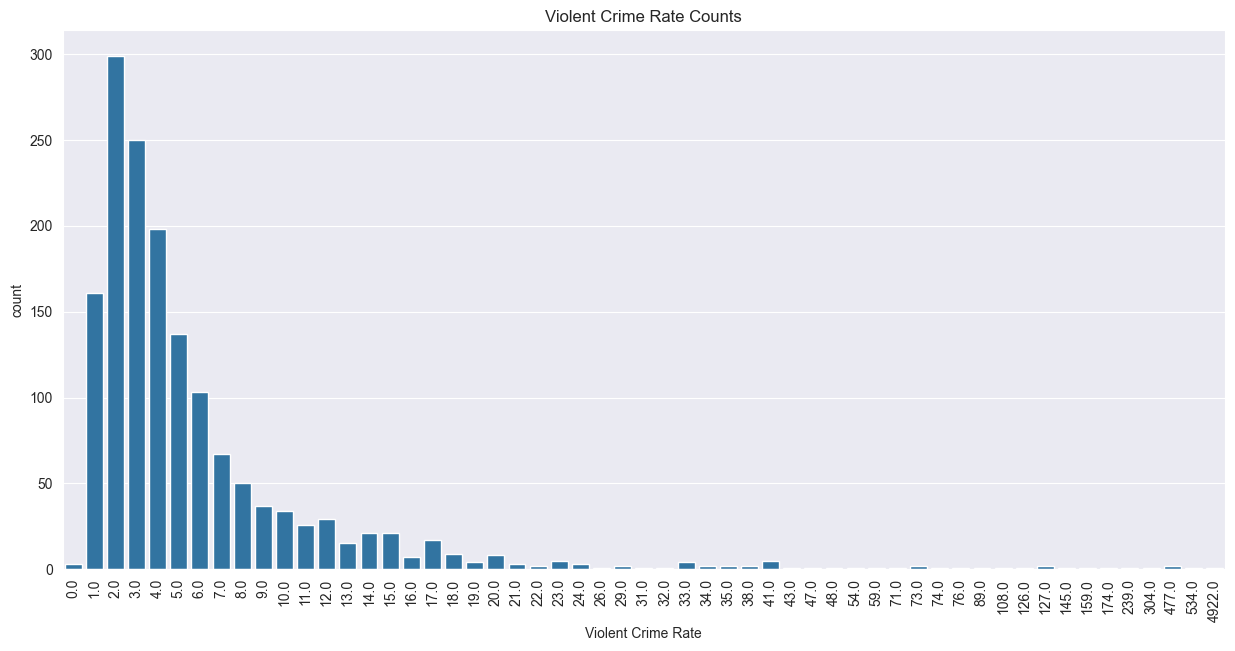

In [82]:
plt.subplots(figsize = (15,7))
sns.countplot(x=df2_new['Violent Crime Rate'])
plt.title('Violent Crime Rate Counts')
plt.xticks(rotation = 90)
plt.show()

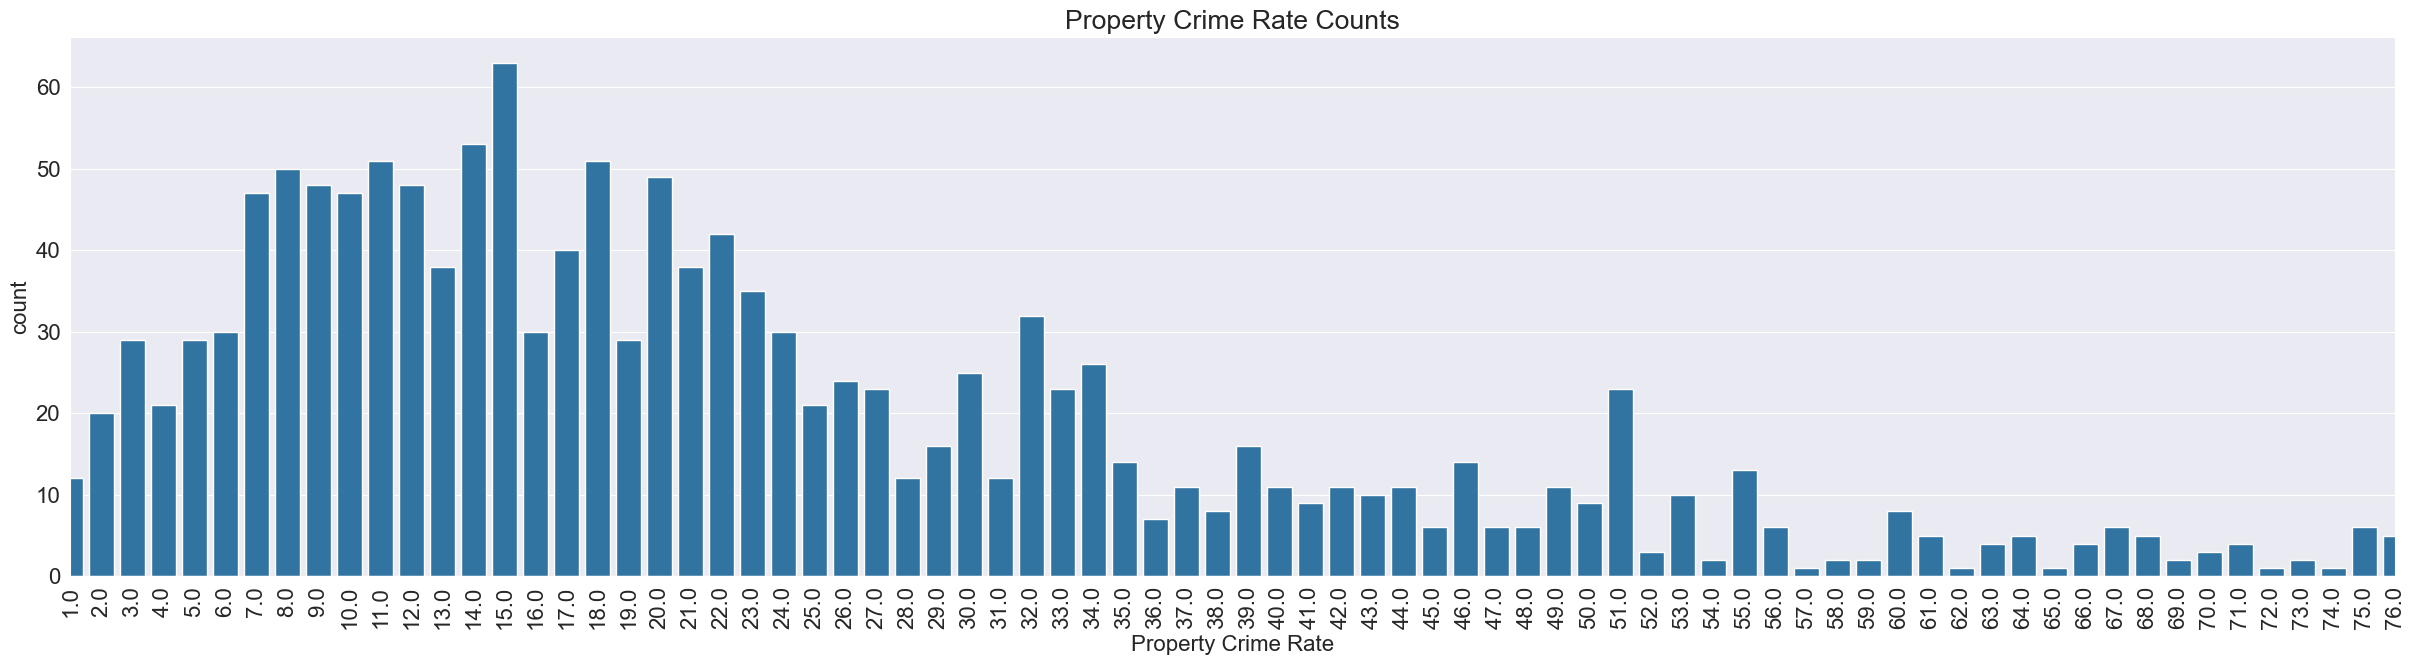

In [147]:
plt.rcParams.update({'font.size': 16})
plt.subplots(figsize = (30,7))
sns.countplot(x=df2_new['Property Crime Rate'])
plt.title('Property Crime Rate Counts')
plt.xticks(rotation = 90)
plt.xlim(left=0, right=75)

plt.show()

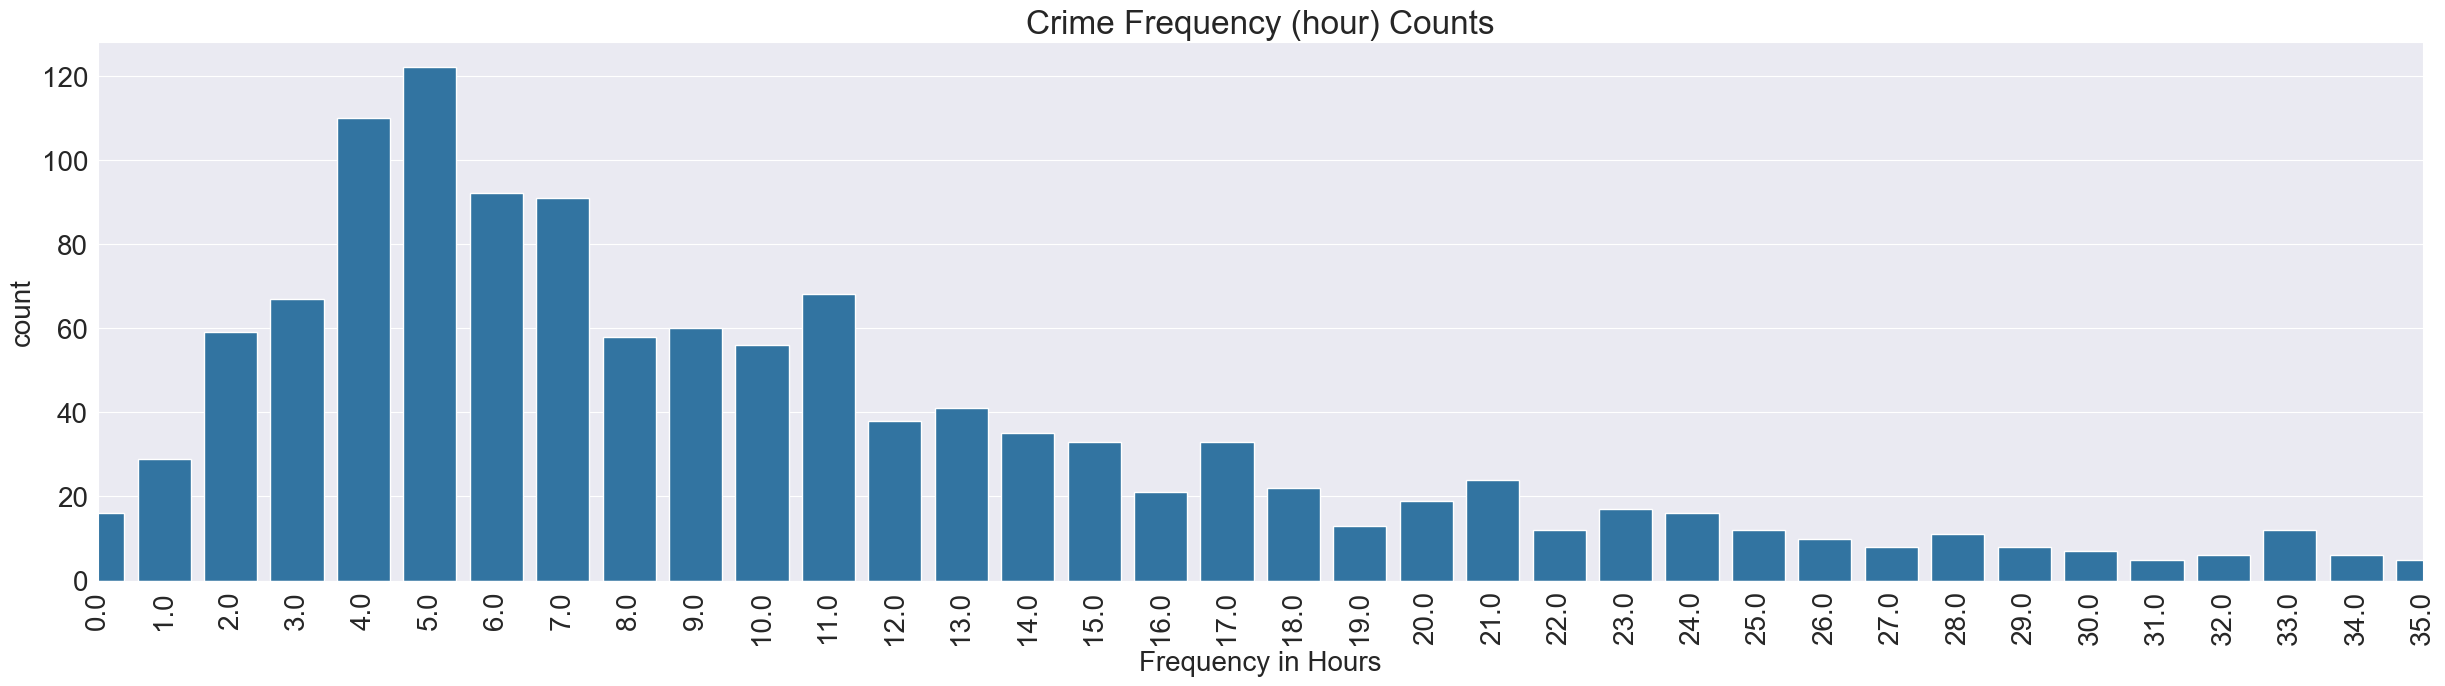

In [187]:
plt.subplots(figsize = (30,7))
plt.rcParams.update({'font.size': 20})
sns.countplot(x=df2_new['Frequency in Hours'])
plt.title('Crime Frequency (hour) Counts')
plt.xticks(rotation = 90)
plt.xlim(left=0, right=35)
plt.show()

Dataset 3 EDA
---

In [323]:
df3 = pd.read_csv(r'clean_Zip_zhvi.csv')

In [329]:
df3.head()

,Zip Code,2023-06-30,2023-09-30,2023-12-31,2024-03-31,Average House Price
0,'77494',481531.770944,488672.706004,491236.726086,497633.682304,489768.721334
1,'08701',542238.662882,560433.407041,579209.518786,588383.424533,567566.253310
2,'77449',278227.439797,280436.466336,279896.109545,282060.397358,280155.103259
3,'11368',476324.274236,473866.596636,463909.897770,462496.331770,469149.275103
4,'77084',273028.966082,275197.791142,274336.157995,275920.544246,274620.864866


In [330]:
df3.shape

(26350, 6)

In [334]:
df3.describe().round(2)

,2023-06-30,2023-09-30,2023-12-31,2024-03-31,Average House Price
count,25884.00,25885.00,26234.00,26350.00,25884.00
mean,337522.83,343064.54,343506.56,345050.40,343282.55
std,306073.84,314139.15,316821.32,317023.83,314247.02
min,26461.48,26863.76,26045.50,27900.02,27210.27
25%,171704.26,173654.95,172834.37,173495.84,173514.55
50%,257529.77,261492.24,261477.82,263129.08,261509.12
75%,397784.30,403613.49,404006.38,406553.45,404098.71
max,7855186.58,7933379.77,7859018.83,7711460.45,7839761.41


In [328]:
df3.rename(columns={'RegionName': 'Zip Code'}, inplace=True)
df3['Zip Code'] = df3['Zip Code'].astype(str)
df3['Zip Code'] = df3['Zip Code'].apply(lambda x: '0' + x if len(x) == 4 else x)
df3['Zip Code'] = df3['Zip Code'].apply(lambda x: "'" + x + "'")

In [336]:
import numpy as np

df3['Average House Price'] = np.round(df3['Average House Price'] / 5000) * 5000

In [337]:
local_tuition = df3['Average House Price'].value_counts()
print(local_tuition)

Average House Price
185000.0     434
170000.0     425
180000.0     422
175000.0     422
160000.0     417
            ... 
2100000.0      1
1710000.0      1
1555000.0      1
25000.0        1
4565000.0      1
Name: count, Length: 481, dtype: int64


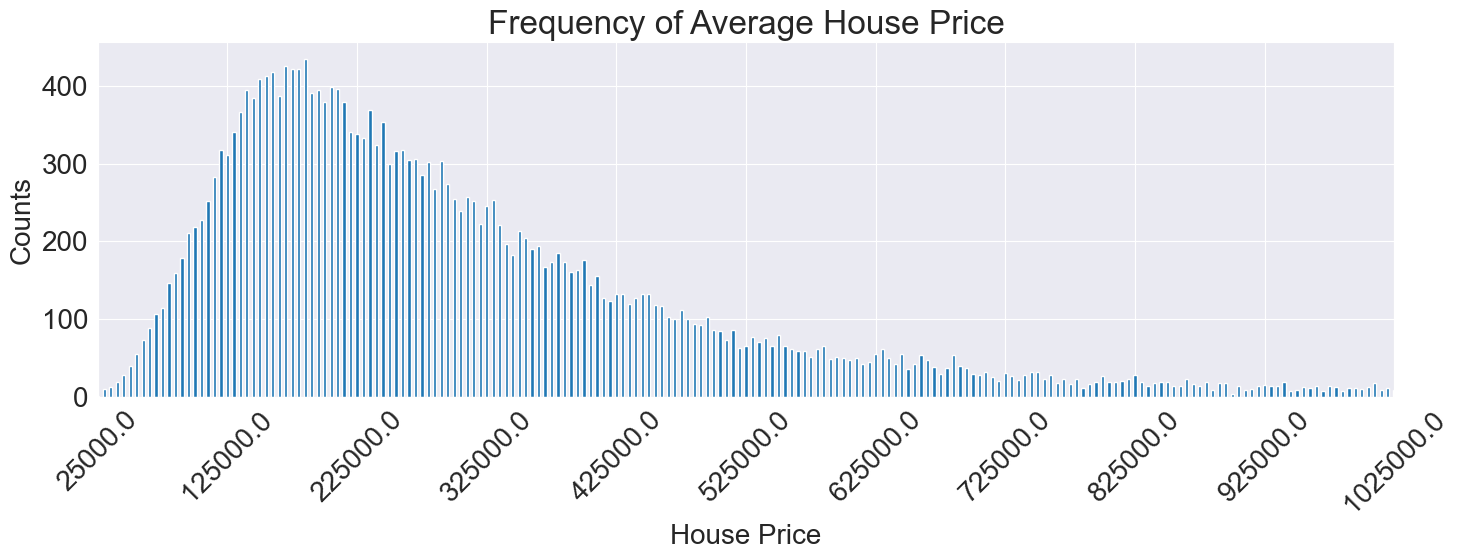

In [339]:
local_tuition_sorted = local_tuition.sort_index()

plt.figure(figsize=(15, 6))  
local_tuition_sorted.plot(kind='bar')
plt.title('Frequency of Average House Price')
plt.xlabel('House Price')
plt.ylabel('Counts')
plt.xticks(rotation=45)  
n = 20  
plt.xticks(range(0, len(local_tuition_sorted), n), local_tuition_sorted.index[::n], rotation=45)
plt.xlim(left=0, right=200)

plt.tight_layout()  
plt.show()

Data Combination
---

In [297]:
merged_df1_df2 = df1.merge(df2, on='Zip Code',how='inner')

merged_df = merged_df1_df2.merge(df3, on='Zip Code', how='inner')

In [298]:
new_df = merged_df[['University','Rank','Average Tuition','Overall Grade','Violent Crime Rate','Property Crime Rate','Frequency in Hours','Average House Price']].copy()

In [299]:
new_df = new_df.drop_duplicates()

In [315]:
file_path = r'dsci_510_dataset.csv'
new_df.to_csv(file_path, index=False)
print(f"DataFrame has been successfully written to '{file_path}'")

DataFrame has been successfully written to 'C:\Users\曾雯\Desktop\dsci_510_dataset.csv'


In [300]:
new_df1 = new_df[['Rank','Average Tuition','Violent Crime Rate','Property Crime Rate','Frequency in Hours','Average House Price']].copy()

In [301]:
new_df1.shape

(1272, 6)

Graph Generation
---

In [344]:
filtered_df = new_df[new_df['Rank'] < 50]
sorted_df = filtered_df.sort_values(by=['Frequency in Hours', 'Average Tuition', 'Average House Price'], 
                                    ascending=[False, True, True])

sorted_df.head(5)

,University,Rank,Average Tuition,Overall Grade,Violent Crime Rate,Property Crime Rate,Frequency in Hours,Average House Price
17,University of Virginia,33,13.0,B-,1.636,12.61,10.683333,490000.0
0,Massachusetts Institute of Technology,1,17.0,C-,4.434,23.67,6.883333,945000.0
3,Stanford University,3,17.0,D-,7.027,36.73,4.483333,3095000.0
20,Tufts University,45,17.0,D-,2.187,24.03,4.033333,780000.0
21,Washington University in St. Louis,47,17.0,D-,6.417,59.29,4.016667,250000.0


In [345]:
sorted_df.tail(5)

,University,Rank,Average Tuition,Overall Grade,Violent Crime Rate,Property Crime Rate,Frequency in Hours,Average House Price
18,Boston University,40,17.0,F,14.880,133.00,2.033333,665000.0
16,University of Illinois Urbana-Champaign,30,11.5,F,11.430,91.61,1.833333,150000.0
9,University of Chicago,16,17.0,F,15.720,68.45,1.516667,205000.0
7,University of Pennsylvania,9,17.0,F,11.410,70.79,1.466667,205000.0
4,Columbia University in the City of New York,8,17.0,F,5.517,49.25,1.083333,820000.0


In [304]:
filtered_df2 = new_df[new_df['Rank'] < 100]
filtered_df2.describe()

,Rank,Average Tuition,Violent Crime Rate,Property Crime Rate,Frequency in Hours,Average House Price
count,31.000000,31.000000,31.000000,31.000000,31.000000,3.100000e+01
mean,51.612903,14.500000,7.195839,46.322194,7.964516,7.577419e+05
std,34.117129,3.309078,4.595318,40.622882,12.185390,6.752516e+05
min,1.000000,7.500000,1.169000,7.029000,1.066667,1.500000e+05
25%,20.000000,11.000000,2.914500,20.940000,3.041667,2.825000e+05
50%,47.000000,17.000000,6.857000,33.650000,4.250000,6.050000e+05
75%,83.500000,17.000000,10.405000,54.990000,8.458333,8.950000e+05
max,99.000000,17.000000,15.720000,198.800000,68.000000,3.095000e+06


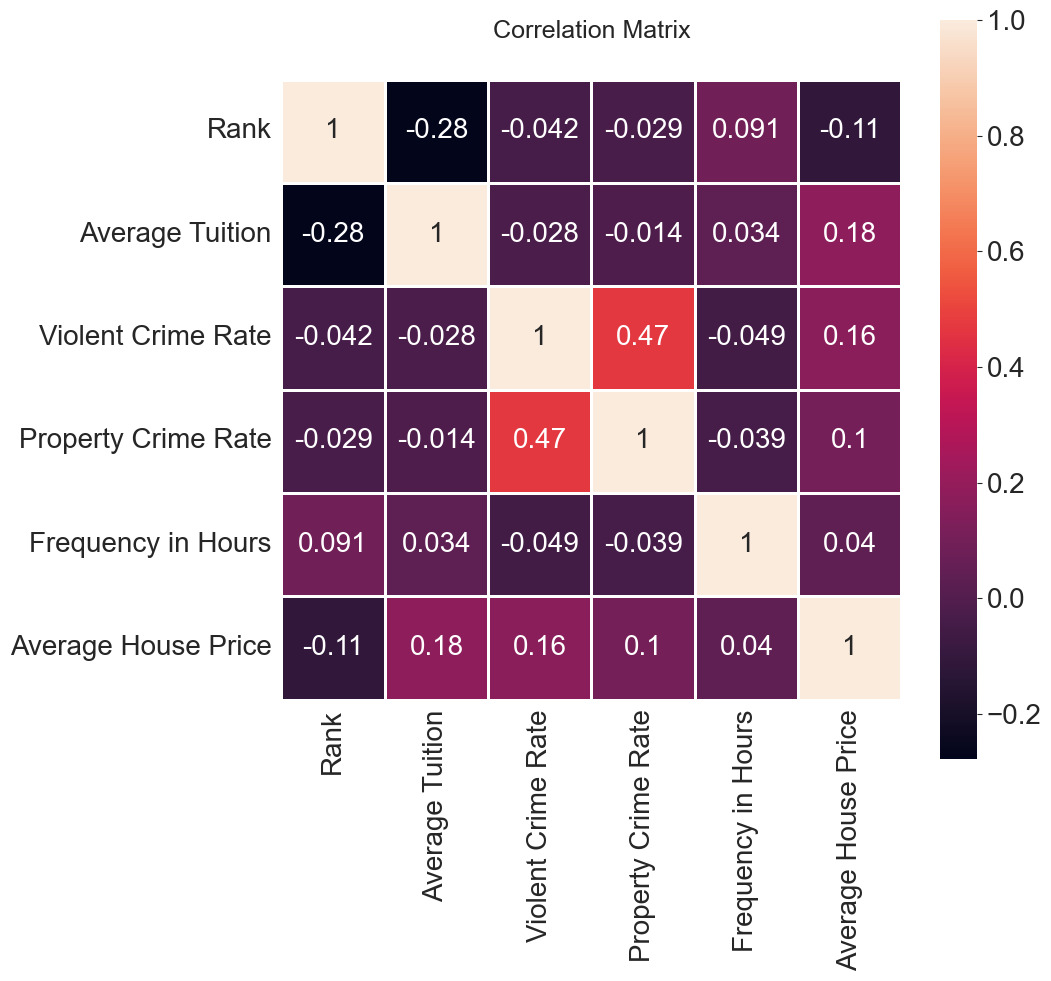

In [305]:
plt.figure(figsize=(10, 10))
sns.heatmap(new_df1.corr(),annot=True,square=True,linewidth=2,cbar_kws={'shrink':0.96})
plt.title('Correlation Matrix',fontsize=18, pad=30)
plt.savefig('Heatmap_full.png',bbox_inches = 'tight',dpi=600)


In [347]:
from scipy.stats import pearsonr

merged_df = merged_df.dropna(subset=['Rank', 'Average House Price'])
correlation, p_value = pearsonr(merged_df['Rank'], merged_df['Average House Price'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Rank' and 'Average House Price'.")
else:
    print("There is no significant correlation between 'Rank' and 'Average House Price'.")

p-value is 2.07104932706156e-06
There is a significant correlation between 'Rank' and 'Average House Price'.


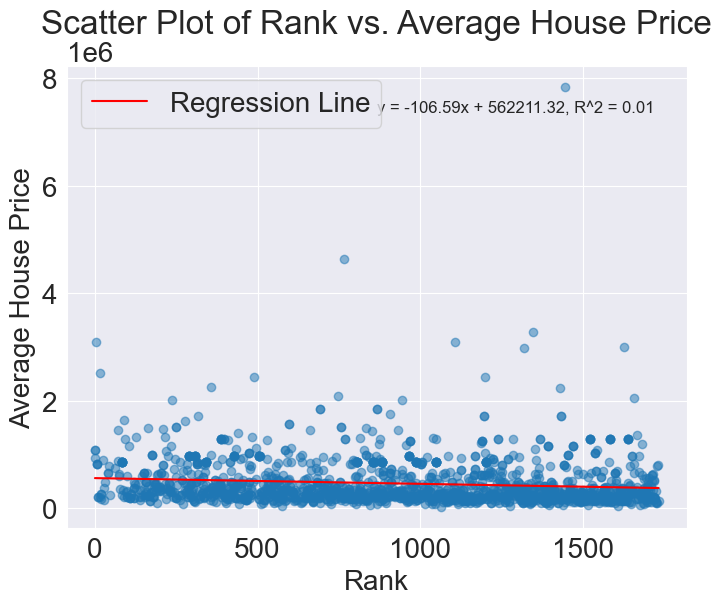

In [346]:
from scipy.stats import linregress
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Rank'], merged_df['Average House Price'], alpha=0.5)

slope, intercept, r_value, p_value, std_err = linregress(merged_df['Rank'], merged_df['Average House Price'])
x_values = np.linspace(merged_df['Rank'].min(), merged_df['Rank'].max(), 100)
y_values = slope * x_values + intercept

plt.plot(x_values, y_values, color='red', label='Regression Line')
equation = f'y = {slope:.2f}x + {intercept:.2f}, R^2 = {r_value**2:.2f}' 
plt.text(0.5, 0.9, equation, fontsize=12, transform=plt.gca().transAxes)

plt.title('Scatter Plot of Rank vs. Average House Price')
plt.xlabel('Rank')
plt.ylabel('Average House Price')
plt.grid(True)
plt.legend()
plt.show()

In [348]:
merged_df = merged_df.dropna(subset=['Rank', 'Average Tuition'])
correlation, p_value = pearsonr(merged_df['Rank'], merged_df['Average Tuition'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Rank' and 'Average Tuition'.")
else:
    print("There is no significant correlation between 'Rank' and 'Average Tuition'.")

p-value is 4.69504950009481e-41
There is a significant correlation between 'Rank' and 'Average Tuition'.


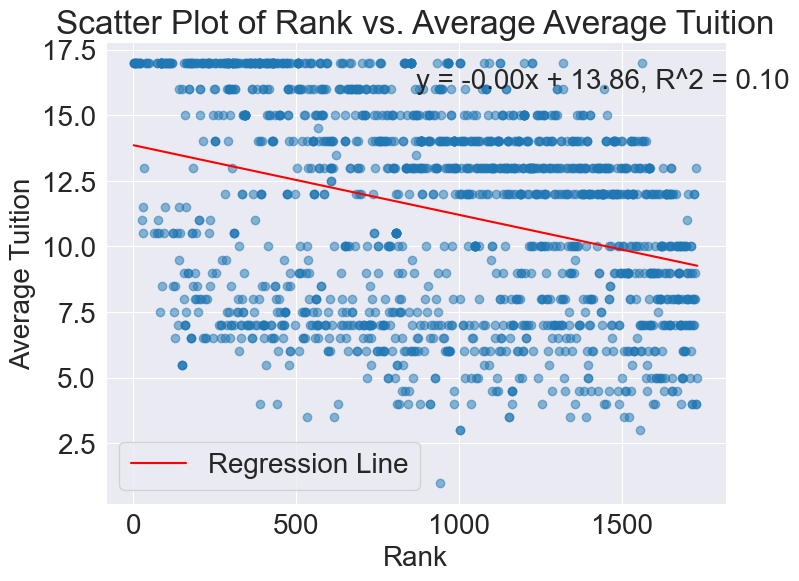

In [349]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Rank'], merged_df['Average Tuition'], alpha=0.5)

slope, intercept, r_value, p_value, std_err = linregress(merged_df['Rank'], merged_df['Average Tuition'])
x_values = np.linspace(merged_df['Rank'].min(), merged_df['Rank'].max(), 100)
y_values = slope * x_values + intercept

plt.plot(x_values, y_values, color='red', label='Regression Line')
equation = f'y = {slope:.2f}x + {intercept:.2f}, R^2 = {r_value**2:.2f}' 
plt.text(0.5, 0.9, equation, fontsize=20,  transform=plt.gca().transAxes)

plt.title('Scatter Plot of Rank vs. Average Average Tuition')
plt.xlabel('Rank')
plt.ylabel('Average Tuition')
plt.grid(True)
plt.legend()
plt.show()

In [350]:
from scipy.stats import pearsonr

merged_df = merged_df.dropna(subset=['Rank', 'Frequency in Hours'])
correlation, p_value = pearsonr(merged_df['Rank'], merged_df['Frequency in Hours'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Rank' and 'Frequency in Hours'.")
else:
    print("There is no significant correlation between 'Rank' and 'Frequency in Hours'.")

p-value is 0.0007426251295918862
There is a significant correlation between 'Rank' and 'Frequency in Hours'.


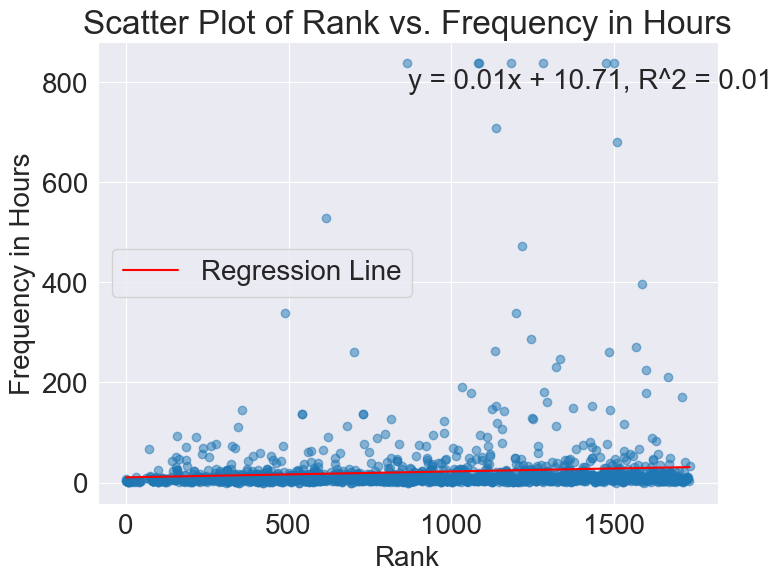

In [351]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Rank'], merged_df['Frequency in Hours'], alpha=0.5)

slope, intercept, r_value, p_value, std_err = linregress(merged_df['Rank'], merged_df['Frequency in Hours'])
x_values = np.linspace(merged_df['Rank'].min(), merged_df['Rank'].max(), 100)
y_values = slope * x_values + intercept

plt.plot(x_values, y_values, color='red', label='Regression Line')
equation = f'y = {slope:.2f}x + {intercept:.2f}, R^2 = {r_value**2:.2f}' 
plt.text(0.5, 0.9, equation, fontsize=20,  transform=plt.gca().transAxes)

plt.title('Scatter Plot of Rank vs. Frequency in Hours')
plt.xlabel('Rank')
plt.ylabel('Frequency in Hours')
plt.grid(True)
plt.legend()
plt.show()

In [352]:
from scipy.stats import pearsonr

merged_df = merged_df.dropna(subset=['Rank', 'Violent Crime Rate'])
correlation, p_value = pearsonr(merged_df['Rank'], merged_df['Violent Crime Rate'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Rank' and 'Violent Crime Rate'.")
else:
    print("There is no significant correlation between 'Rank' and 'Violent Crime Rate'.")

p-value is 0.12099440267498593
There is no significant correlation between 'Rank' and 'Violent Crime Rate'.


In [353]:
from scipy.stats import pearsonr

merged_df = merged_df.dropna(subset=['Rank', 'Property Crime Rate'])
correlation, p_value = pearsonr(merged_df['Rank'], merged_df['Property Crime Rate'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Rank' and 'Property Crime Rate'.")
else:
    print("There is no significant correlation between 'Rank' and 'Property Crime Rate'.")

p-value is 0.2826241511505945
There is no significant correlation between 'Rank' and 'Property Crime Rate'.


In [354]:
from scipy.stats import pearsonr

merged_df = merged_df.dropna(subset=['Average Tuition', 'Frequency in Hours'])
correlation, p_value = pearsonr(merged_df['Average Tuition'], merged_df['Frequency in Hours'])
print(f'p-value is {p_value}')
alpha = 0.05
if p_value < alpha:
    print("There is a significant correlation between 'Average Tuition' and 'Frequency in Hours'.")
else:
    print("There is no significant correlation between 'Average Tuition' and 'Frequency in Hours'.")

p-value is 0.9325754242861386
There is no significant correlation between 'Average Tuition' and 'Frequency in Hours'.
